## All the -ve log-likelihood plots for different parameters of anisotropy function

In [2]:
from I3Tray import *
from icecube import icetray, dataclasses, phys_services, sim_services, dataio,  earthmodel_service, neutrino_generator, tableio, hdfwriter
from icecube.simprod import segments
from icecube.icetray import I3Units, I3Frame
from icecube.dataclasses import I3Particle
from icecube.simclasses import I3MMCTrack
from icecube.icetray import I3Units, OMKey, I3Frame
import numpy as np
from matplotlib import pyplot as plt
from Reconstruction.llh.reco_pdfs import cpandel as pdf
import numpy as np
import sys, os
import math
from os import path
from scipy import stats
from scipy.stats import norm
import random as rand
import scipy.special as sp
from scipy import optimize as op
import time

In [3]:
def frame_absent(run_num):
    if (run_num==6 or run_num==14 or run_num==36 or run_num==41 or run_num==49 or run_num==54 or run_num==59 or run_num==61 or run_num==76 or run_num==80 or run_num==82 or run_num==106 or run_num==131 or run_num==133 
        or run_num==129 or run_num==140 or run_num==149 or run_num==155 or run_num==172 or run_num==176 or run_num==147 or run_num==189 or run_num==193 or run_num==198 or run_num==208 or run_num==214 or run_num==216
        or run_num==223 or run_num==235 or run_num==238 or run_num==252 or run_num==284 or run_num==288 or run_num==311 or run_num==369 or run_num==371 or run_num==377 or run_num==379 or run_num==378 or run_num==385 or run_num==389 or run_num==390 
        or run_num==391 or run_num==392 or run_num==393 or run_num==397 or run_num==594
        or run_num==395 or run_num==399 or run_num==401 or run_num==403 or run_num==419 or run_num==471 or run_num==521 or run_num==522 or run_num==550 or run_num==538 or run_num==574 or 
        run_num==584 or run_num==569 or run_num==643 or run_num==646 or run_num==647 or run_num==648 
        or run_num==650 or run_num==656 or run_num==657
        or run_num==658 or run_num==659 or run_num==665 or run_num==675 or run_num==683 or run_num==685 or run_num==686 or run_num==708 or run_num==711
        or run_num==714 or run_num==726 or run_num==737 or run_num==835 or run_num==873 or run_num==889 or run_num==746 or run_num==837 or run_num==867 or run_num==878 or run_num==917 or run_num==944 or run_num==949 or run_num==954 or run_num==963 or run_num==971
        or run_num==972 or run_num==895 or run_num==984 or run_num==987 or run_num==988 or run_num==989):
        return True
    else:
        return False

In [4]:
def GetGeoTime(position,vert) :
    c = 0.299792458                                 # speed of light 
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n = c/ngroup                                     # light in water
    x = position.x - vert.x
    y = position.y - vert.y
    z = position.z - vert.z
    dc = np.sqrt(x*x + y*y + z*z)
    t = dc/c_n
    return dc,t

In [5]:
def anisotropy(position,vert,direction):
    #amp=1251.5
    #print("k:",k)
    amp=[1191.9,1224.2,1251.6,1273.8,1290.9,1303.0,1310.2,1313.0,1313.0,1311.8,1307.0,1299.0,1288.4,1275.6,1260.9,1251.1,1227.6,1209.6,1191.0,1172.0,1152.7,
        1133.4,1114.1,1095.0,1076.1,1057.4,1039.0,1021.0,1003.3,986.0]
    x1=-(vert.x-position.x)
    y1=-(vert.y-position.y)
    z1=-(vert.z-position.z)
    r1= math.sqrt(x1*x1+y1*y1+z1*z1)

    x2= direction.x
    y2= direction.y
    z2= direction.z         
    zeta=np.arccos((x1*x2+y1*y2+z1*z2)/r1)    
    weight= amp[int(k*10)-1]*((np.exp(k*np.cos(zeta))*(np.sin(zeta)))*(k/(2*np.sinh(k))))
    #print("k,weight:",k,weight)

    return weight

In [6]:
def GetVertexTime(pulse_series,geo_doms):
    
    c = 0.299792458                                 # speed of light
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n= c/ngroup                                     # light in water
    ismc = False
    if(type(pulse_series) == 'icecube.dataclasses.I3RecoPulseSeriesMap') :
        ismc = True

    totalcharge = 0.0
    vx = 0.0
    vy = 0.0
    vz = 0.0

    for domkey in pulse_series.keys() :
        domkey_nopmt =  OMKey(domkey.string, domkey.om, 0)
        for pulse in pulse_series[domkey] :
            totalcharge += pulse.charge     
            vx += geo_doms[domkey_nopmt].position.x*pulse.charge
            vy += geo_doms[domkey_nopmt].position.y*pulse.charge
            vz += geo_doms[domkey_nopmt].position.z*pulse.charge

    vertex = dataclasses.I3Position(vx/totalcharge,vy/totalcharge,vz/totalcharge)
    
    #print("GetVertexTime:",vertex)

    T0 = 0.0

    for domkey in pulse_series.keys() :
        domkey_nopmt =  OMKey(domkey.string, domkey.om, 0)
        for pulse in pulse_series[domkey] :
            dx = vertex.x - geo_doms[domkey_nopmt].position.x
            dy = vertex.y - geo_doms[domkey_nopmt].position.y
            dz = vertex.z - geo_doms[domkey_nopmt].position.z
            dist = np.sqrt(dx*dx+dy*dy+dz*dz)
            T0 += pulse.time - dist/c_n

    T0 /= totalcharge
    T0 -= 5.0
    return T0, vertex

In [7]:
def LikelihoodFunctor(data,domsUsed):
    
    pulse_series = data
    geo_doms = domsUsed
    c = 0.299792458                                 # speed of light
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n = c/ngroup                                     # light in water
    lambda_s = 120.                                 # scattering length of light for violet light
    lambda_a = 15.                                  # absorption length of light for violet light
    tau = 18.949132224466762                        # time parameter that has to be fit using simulations or data

    
    # uses the prior defined functions to build a likelihood function that when given a track (linefit) will produce a negative loglikelihood value
    def likelihoodFunction(vert_x, vert_y, vert_z, theta, phi, t0):

        dark = 1.e-15
        vertex = dataclasses.I3Position(vert_x, vert_y, vert_z)
        direction = dataclasses.I3Direction(np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta))  
    
        sum_nloglike = 0.0
        for dom in pulse_series.keys() :
            domkey =  OMKey(dom.string, dom.om, 0)
            dc,t = GetGeoTime(geo_doms[domkey].position,vertex)
            p_charge = np.exp(-dc/tau)/max(dc,0.25)
            
            for pulse in pulse_series[dom] :
                charge = 1.0
                cpandel_out = pdf(pulse.time - t0 - t ,dc)
                if(type(pulse_series) == 'icecube.dataclasses.I3RecoPulseSeriesMap') :
                    charge = pulse.charge                
                
                sum_nloglike -= charge*np.log(cpandel_out*p_charge+dark*anisotropy(geo_doms[domkey].position,vertex,direction)+dark)
                sum_nloglike -= charge*min(0.0,pulse.time - t0 - t)
                
        return sum_nloglike
    
    return likelihoodFunction

In [25]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_nutau=4
nllh=np.zeros(shape=[30])
count=0
vertexRad=311

for i in range(0,200):
    print("file:",i)
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            for frame in infile:
                count=count+1
                if(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12 or frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    pulses=0
                    pulseseriesmap=frame['I3Photons_PMTResponse']
                    for omkey in pulseseriesmap.keys():
                        for pulse in pulseseriesmap[omkey]:
                            pulses=pulses+1

                    data = frame['I3Photons_PMTResponse']
                    MMCTrackList=frame['MMCTrackList']
                    secondary=MMCTrackList[0].GetI3Particle()
                    qFunctor = LikelihoodFunctor(data,domsUsed)
                    direction = secondary.dir
                    T0=secondary.time-frame['TimeShiftedMCPEMap_toffset'].value
                    x=secondary.pos.x
                    y=secondary.pos.y
                    z=secondary.pos.z
                
                    row=-1
                    k=0
                    while(k<=3):
                        row=row+1
                        k+=0.1
                        def func(x):
                            vert_x, vert_y, vert_z, theta, phi, t0 = x
                            return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                        solution=func(np.array([x,y,z,secondary.dir.theta,secondary.dir.phi,T0]))/(pulses-nfitparameters_nutau)
                        print(solution)
                        nllh[row]=nllh[row]+solution
                        
for i in range(0,30):
    nllh[i]=nllh[i]/count

file: 0
24.788509512683227
24.78541050248014
24.782510842704752
24.779820304366407
24.77733883370488
24.775067125042348
24.77300637370518
24.771225061929982
24.769447954295885
24.76783194937432
24.766332899446315
24.76525533126903
24.764202230072648
24.763301868426588
24.762546132181154
24.761722183600156
24.761413546331635
24.76101636918308
24.760720500496365
24.76051752916955
24.760402022727693
24.760361294325488
24.760392692811813
24.7604863264607
24.760639295192078
24.760848788355485
24.761108232420707
24.761410881869786
24.76175781291298
24.762142349455818
54.397247091269925
54.38160214890978
54.36674422243391
54.35276155046379
54.33968704184233
54.32755063718896
54.31637928556841
54.3065298674306
54.29664729728363
54.28751984857964
54.27893546562734
54.27241890544782
54.26599650434137
54.26031184744233
54.25532810225604
54.24998387712306
54.24720098717486
54.24396134663913
54.2412169678092
54.23892791785339
54.23706906732442
54.23557864361676
54.234445192992375
54.23362064503006


In [27]:
print(nllh)

[16.41833018 16.41375648 16.40956881 16.40577989 16.40238424 16.39937725
 16.3967549  16.39462778 16.39252113 16.39069946 16.3890842  16.38817936
 16.38731563 16.3867039  16.386327   16.38583422 16.38617439 16.38636
 16.38669852 16.38717438 16.38777707 16.38848482 16.3892921  16.39018214
 16.39114943 16.3921887  16.39328896 16.39443913 16.39564036 16.39688191]


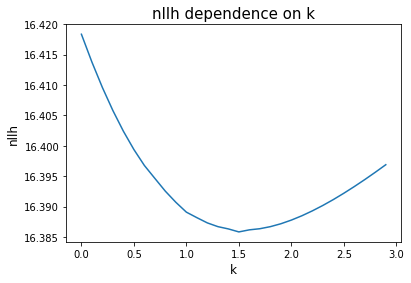

In [30]:
k=np.arange(0,30)
plt.plot(k,nllh)
positions_x=(0,5,10,15,20,25,30)
labels_x=("0.0","0.5","1.0","1.5","2.0","2.5","3.0")
plt.xticks(positions_x, labels_x)
plt.xlabel("k",fontsize=12)
plt.ylabel("nllh",fontsize=12)
plt.title("nllh dependence on k",fontsize=15)

#x1=[3,3]
#y1=[1814.45,1814.5]
#plt.plot(x1,y1,linewidth=2,linestyle='dashed',color='orange', label="alpha="+str(0.4))
#x2=[1,7]
#y2=[np.min(nllh),np.min(nllh)]
#plt.plot(x2,y2,linewidth=2,linestyle='dashed',color='black', label="Min_nllh="+str(np.min(nllh)))
#plt.legend(loc="upper left")

plt.show()

### Histogram for different k's

In [8]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_nutau=4
vertexRad=311
hist_k=[]
solution_k=[]

for i in range(0,1000):
    print("file:",i)
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            for frame in infile:
                if(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12 or frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    pulses=0
                    pulseseriesmap=frame['I3Photons_PMTResponse']
                    for omkey in pulseseriesmap.keys():
                         for pulse in pulseseriesmap[omkey]:
                            pulses=pulses+1
                    data = frame['I3Photons_PMTResponse']
                    llhfit=frame['llhfit']
                    linefit=frame['linefit']
                    direction = dataclasses.I3Direction(llhfit.dir.x,llhfit.dir.y,llhfit.dir.z)
                    MMCTrackList=frame['MMCTrackList']
                    secondary=MMCTrackList[0].GetI3Particle()
                    qFunctor = LikelihoodFunctor(data,domsUsed)
                    T0=secondary.time-frame['TimeShiftedMCPEMap_toffset'].value
                    x=secondary.pos.x
                    y=secondary.pos.y
                    z=secondary.pos.z
                    k=0
                    nllh_min=100000
                    k_min=10
                    
                    while(k<=3):
                        k=k+0.1
                        def func(x):
                            vert_x, vert_y, vert_z, theta, phi, t0 = x
                            return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                        solution=func(np.array([x,y,z,secondary.dir.theta,secondary.dir.phi,T0]))/(pulses-nfitparameters_nutau)
                        if(solution<nllh_min):
                            nllh_min=solution
                            k_min=k  
                    
                    solution_k.append(nllh_min)
                    hist_k.append(k_min)

file: 0
file: 1
file: 2
file: 3
file: 4
file: 5
file: 6
file: 7
file: 8
file: 9
file: 10
file: 11
file: 12
file: 13
file: 14
file: 15
file: 16
file: 17
file: 18
file: 19
file: 20
file: 21
file: 22
file: 23
file: 24
file: 25
file: 26
file: 27
file: 28
file: 29
file: 30
file: 31
file: 32
file: 33
file: 34
file: 35
file: 36
file: 37
file: 38
file: 39
file: 40
file: 41
file: 42
file: 43
file: 44
file: 45
file: 46
file: 47
file: 48
file: 49
file: 50
file: 51
file: 52
file: 53
file: 54
file: 55
file: 56
file: 57
file: 58
file: 59
file: 60
file: 61
file: 62
file: 63
file: 64
file: 65
file: 66
file: 67
file: 68
file: 69
file: 70
file: 71
file: 72
file: 73
file: 74
file: 75
file: 76
file: 77
file: 78
file: 79
file: 80
file: 81
file: 82
file: 83
file: 84
file: 85
file: 86
file: 87
file: 88
file: 89
file: 90
file: 91
file: 92
file: 93
file: 94
file: 95
file: 96
file: 97
file: 98
file: 99
file: 100
file: 101
file: 102
file: 103
file: 104
file: 105
file: 106
file: 107
file: 108
file: 109
file: 110


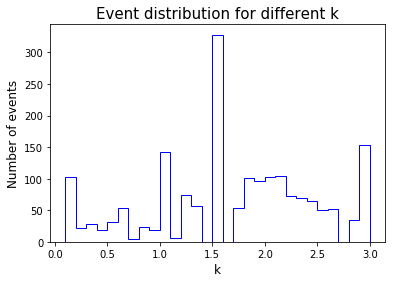

In [9]:
plt.hist(hist_k, bins=29, histtype='step',color='blue')
#plt.legend(loc='upper center')
plt.xlabel('k',fontsize=12)
plt.ylabel('Number of events',fontsize=12)
plt.title("Event distribution for different k",fontsize=15)
plt.ticklabel_format(style='plain')
#plt.xlim(0,0.5)
plt.show()

### Energy vs k 2D histogram

In [14]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_nutau=4
count=0
hist_k_energy=[]
energy_list=[]

for i in range(0,1000):
    print("file:",i)
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            for frame in infile:
                if(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12 or frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    if(frame['NuGPrimary'].energy<=1000000):
                        pulses=0
                        pulseseriesmap=frame['I3Photons_PMTResponse']
                        for omkey in pulseseriesmap.keys():
                             for pulse in pulseseriesmap[omkey]:
                                pulses=pulses+1

                        data = frame['I3Photons_PMTResponse']
                        llhfit=frame['llhfit']
                        linefit=frame['linefit']
                        direction = dataclasses.I3Direction(llhfit.dir.x,llhfit.dir.y,llhfit.dir.z)
                        MMCTrackList=frame['MMCTrackList']
                        secondary=MMCTrackList[0].GetI3Particle()
                        qFunctor = LikelihoodFunctor(data,domsUsed)
                       # T0, vertex = GetVertexTime(data,domsUsed)
                        T0=secondary.time-frame['TimeShiftedMCPEMap_toffset'].value
                        x=secondary.pos.x
                        y=secondary.pos.y
                        z=secondary.pos.z
                    
                        k=0
                        nllh_min=100000
                        k_min=11
                    
                        while(k<=3):
                            k=k+0.1
                            def func(x):
                                vert_x, vert_y, vert_z, theta, phi, t0 = x
                                return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                            solution=func(np.array([x,y,z,secondary.dir.theta,secondary.dir.phi,T0]))/(pulses-nfitparameters_nutau)    
                            if(solution<nllh_min):
                                nllh_min=solution
                                k_min=k

                        energy_list.append(frame['NuGPrimary'].energy)
                        hist_k_energy.append(k_min)

file: 0
file: 1
file: 2
file: 3
file: 4
file: 5
file: 6
file: 7
file: 8
file: 9
file: 10
file: 11
file: 12
file: 13
file: 14
file: 15
file: 16
file: 17
file: 18
file: 19
file: 20
file: 21
file: 22
file: 23
file: 24
file: 25
file: 26
file: 27
file: 28
file: 29
file: 30
file: 31
file: 32
file: 33
file: 34
file: 35
file: 36
file: 37
file: 38
file: 39
file: 40
file: 41
file: 42
file: 43
file: 44
file: 45
file: 46
file: 47
file: 48
file: 49
file: 50
file: 51
file: 52
file: 53
file: 54
file: 55
file: 56
file: 57
file: 58
file: 59
file: 60
file: 61
file: 62
file: 63
file: 64
file: 65
file: 66
file: 67
file: 68
file: 69
file: 70
file: 71
file: 72
file: 73
file: 74
file: 75
file: 76
file: 77
file: 78
file: 79
file: 80
file: 81
file: 82
file: 83
file: 84
file: 85
file: 86
file: 87
file: 88
file: 89
file: 90
file: 91
file: 92
file: 93
file: 94
file: 95
file: 96
file: 97
file: 98
file: 99
file: 100
file: 101
file: 102
file: 103
file: 104
file: 105
file: 106
file: 107
file: 108
file: 109
file: 110


In [15]:
for i in range (0,len(energy_list)):
    energy_list[i]=np.log10(energy_list[i])

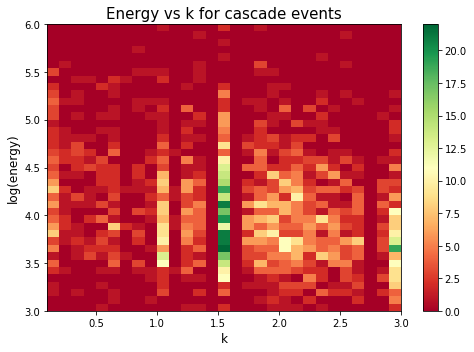

In [16]:
x_min = np.min(hist_k_energy)
x_max = np.max(hist_k_energy)
y_min = np.min(energy_list)
y_max = np.max(energy_list)
x_bins = np.linspace(x_min, x_max, 30)
y_bins = np.linspace(y_min, y_max, 40)

fig, ax = plt.subplots(figsize =(7, 5))
plt.hist2d(hist_k_energy, energy_list, bins =[x_bins, y_bins], cmap='RdYlGn')
plt.title("Energy vs k for cascade events",fontsize=15)
ax.set_ylabel('log(energy)',fontsize=12) 
ax.set_xlabel('k',fontsize=12) 

plt.colorbar()
plt.tight_layout() 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.show()

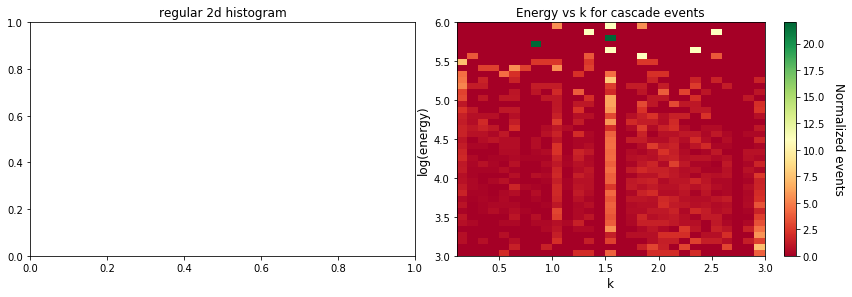

In [40]:
x_min = np.min(hist_k_energy)
x_max = np.max(hist_k_energy)
y_min = np.min(energy_list)
y_max = np.max(energy_list)
x_bins = np.linspace(x_min, x_max, 30)
y_bins = np.linspace(y_min, y_max, 40)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

norm=10
plt.hist2d(hist_k_energy, energy_list, bins=(x_bins, y_bins), cmap='RdYlGn')
ax1.set_title('regular 2d histogram')


hist, xedges, yedges =np.histogram2d(hist_k_energy, energy_list, bins=(x_bins, y_bins))
hist = hist.T
with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
    hist *= norm / hist.sum(axis=1, keepdims=True)
ax2.pcolormesh(xedges, yedges, hist, cmap='RdYlGn')
ax2.set_title('Energy vs k for cascade events')
plt.tight_layout() 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
cbar=plt.colorbar(shrink=1)
cbar.ax.get_yaxis().labelpad = 20
cbar.set_label('Normalized events', rotation=270, fontsize=12)
ax2.set_ylabel('log(energy)',fontsize=12) 
ax2.set_xlabel('k',fontsize=12) 
plt.show()